In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'ColabNotebooks/DRL/CourseWork' 
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['CheeseProblem - Q learning.ipynb', 'Untitled2.ipynb', 'pong', 'Copy of simple_DQN.ipynb', 'Untitled folder', 'DQN_SpaceInvader.ipynb', 'Copy of DQN_SpaceInvader.ipynb', 'Trial-1 Pong_DQN_Rllib.ipynb', 'Q_Learning CheeseMouse Problem.ipynb', 'Pong_PPO.ipynb', 'Pong_DQN_Rllib.ipynb']


### Required Installations for the Lunar Lander problem

In [ ]:
import urllib.request
urllib.request.urlretrieve('http://www.atarimania.com/roms/Roms.rar','Roms.rar')
!pip install unrar
!unrar x Roms.rar
!mkdir rars
!mv HC\ ROMS.zip   rars
!mv ROMS.zip  rars
!python -m atari_py.import_roms rars
!apt-get install -y xvfb x11-utils
!pip install pyvirtualdisplay
!pip install "ray[rllib]" tensorflow torch

!pip install "gym[atari]" "gym[accept-rom-license]" atari_py
!pip install tensorboard

!pip3 install box2d-py
!pip3 install gym[Box_2D]
!python -m atari_py.import_roms ROMS

Streaming output truncated to the last 5000 lines.
Extracting  ROMS/Chopper Command (Hack) (Unknown) (PAL).bin                6%  OK 
Extracting  ROMS/Chopper Command (Unknown) (PAL).bin                       6%  OK 
Extracting  ROMS/Chopper Command - Captain Helicopter (1982) (Activision, Bob Whitehead - Ariola) (EAX-015, EAX-015-04I - 711 015-725) (PAL).bin       6%  OK 
Extracting  ROMS/Chuck Norris Superkicks (1983) (Xonox - K-Tel Software - VSS, Robert Weatherby) (6230, 06002, 06003, 99003) ~.bin       6%  OK 
Extracting  ROMS/Circus (AKA Circus Atari) (Paddle) (Zellers).bin          6%  OK 
Extracting  ROMS/Circus Atari (Paddle) (1980) (Atari, Mike Lorenzen) (CX2630, CX2630P) (PAL).bin       6%  OK 
Extracting  ROMS/Circus Atari (Paddle) (Hack) (32 in 1) (Bit Corporation) (R320).bin       6%  OK 
Extracting  ROMS/Circus Atari (Paddle) (Unknown) (PAL).bin                 6%  OK 
Extracting  ROMS/Circus Atari (

### Required Imports

In [ ]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

In [ ]:
import gym
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import base64, io
import numpy as np
from collections import deque, namedtuple
# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display 
import glob
import pandas as pd
import numpy as np
from IPython import display
from gym.wrappers.monitoring.video_recorder import VideoRecorder
from pyvirtualdisplay import Display
from IPython.display import HTML

%matplotlib inline
from pyvirtualdisplay import Display
display = Display(visible=False, size=(1400, 900))
_ = display.start()


# Lunar Lander

We intend to use reinforcement learning methods to solve the lunar lander environment in the OpenAI gym kit. The environment simulates a situation in which a lander must land in a specific location under low-gravity conditions, and it includes a well-defined physics engine. 
The main goal of the game is to guide the agent as softly and efficiently as possible to the landing pad.

In [ ]:
env = gym.make('LunarLander-v2')
env.seed(0)
print(env.observation_space)

Box(-inf, inf, (8,), float32)


In [ ]:
env.reset()
for i in range(100):
    env.render()
    observation, reward, done, info = env.step(env.action_space.sample()) # take a random action
    print("step", i, reward, done, info)
env.close()

step 0 -1.8939137747137977 False {}
step 1 -0.255552362366177 False {}
step 2 1.4130303923712415 False {}
step 3 1.0988330218752094 False {}
step 4 1.2955965680678787 False {}
step 5 -0.5419368974280292 False {}
step 6 -1.8100930900818912 False {}
step 7 -2.855592615211235 False {}
step 8 -1.183126793945944 False {}
step 9 -2.7065879345734913 False {}
step 10 -2.935527454516489 False {}
step 11 -3.9111227761963208 False {}
step 12 -3.8478887500884285 False {}
step 13 -4.248081721969441 False {}
step 14 -3.561238674306935 False {}
step 15 -2.77671727999376 False {}
step 16 0.9188311873494512 False {}
step 17 -4.288429255084593 False {}
step 18 0.6074073207931121 False {}
step 19 -1.7034582708702601 False {}
step 20 0.4141546985683931 False {}
step 21 -2.6225312447957365 False {}
step 22 -4.329604058650658 False {}
step 23 -2.6805697366389425 False {}
step 24 -1.7779733220874505 False {}
step 25 -2.3068752137306476 False {}
step 26 0.4433184710637022 False {}
step 27 -1.4999140192187952 

In [ ]:
env.seed(0)
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)

State shape:  (8,)
Number of actions:  4


# DQN

### **DQN Implementation**

To estimate the Q values, the deep Q-Learning approach uses a fully connected neural network known as a Deep Q-Network (DQN). The current state (8-dimensional in our case) is fed into the network, and the outputs are the Q values for all state-action pairs for that state.



In [ ]:
class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed):
        """
        Parameters : 
            state_size : DataType int
            action_size : DataType int
            seed : DataType int
        Operation: 
            initializing 3 fully connected networks
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, action_size)
        
    def forward(self, state):
        """
        Param : 
            state : current state 
            DataType : Tensor object
        Operation :
            Network that maps state to action values
        """
        x = self.fc1(state)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        return self.fc3(x)

In [ ]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # batch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4    

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
class DQNAgent():
    """
    Operation : Agent learns from the environment using a DQN approch
    """

    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.
        Params:
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed 
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        '''
        Saves the step in memory and learn every time step
        Params:
          state
          action, reward, next_state, done
        '''
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        # Obtain random minibatch of tuples from D
        states, actions, rewards, next_states, dones = experiences

        ## Compute and minimize the loss
        ### Extract next maximum estimated value from target network
        q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        ### Calculate target value from bellman equation
        q_targets = rewards + gamma * q_targets_next * (1 - dones)
        ### Calculate expected value from local network
        q_expected = self.qnetwork_local(states).gather(1, actions)
        
        ### Loss calculation (we used Mean squared error)
        loss = F.mse_loss(q_expected, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [ ]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [ ]:
def DQNTrainer(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

agent = DQNAgent(state_size=8, action_size=4, seed=0)
scores_dqn = DQNTrainer()

Episode 100	Average Score: -182.63
Episode 200	Average Score: -131.66
Episode 300	Average Score: -61.97
Episode 400	Average Score: -49.02
Episode 500	Average Score: 6.97
Episode 600	Average Score: 76.39
Episode 700	Average Score: 159.14
Episode 770	Average Score: 200.70
Environment solved in 670 episodes!	Average Score: 200.70


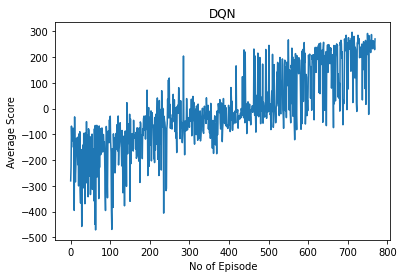

In [ ]:
#updated graph
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores_dqn)), scores_dqn)
plt.ylabel('Average Score')
plt.xlabel('No of Episode')
plt.title('DQN')
plt.show()

*DQN Code Reference : https://goodboychan.github.io/python/reinforcement_learning/pytorch/udacity/2021/05/07/DQN-LunarLander.html*

### **Double Deep Q-Network -DDQN Implementation**

The number of hidden layers is doubled

Double DQN is implemented by using two q. networks, one for action and one for target q network

Observation : Hidden layers doubled improved the performance of the agent

In [ ]:
class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed):
        """
        Parameters : 
            state_size : DataType int
            action_size : DataType int
            seed : DataType int
        Operation: 
            initializing 3 fully connected networks
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, 64*2)
        self.fc2 = nn.Linear(64*2, 128*2)
        self.fc3 = nn.Linear(128*2, action_size)
        
    def forward(self, state):
        """
        Param : 
            state : current state 
            DataType : Tensor object
        Operation :
            Network that maps state to action values
        """
        x = self.fc1(state)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        return self.fc3(x)

In [ ]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # batch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4    

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
class DoubleDQNAgent():
    """
    Operation : Agent learns from the environment using a DQN approch
    """

    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed 
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        # Obtain random minibatch of tuples from D
        states, actions, rewards, next_states, dones = experiences

        ## Compute and minimize the loss
        ### Extract next maximum estimated value from target network
        q_expected = self.qnetwork_local(states).gather(-1, actions)
        with torch.no_grad():
            next_actions = self.qnetwork_local(next_states).argmax(-1, keepdim=True)
            q_targets_next = self.qnetwork_target(next_states).gather(-1, next_actions)
            q_targets = rewards+GAMMA*q_targets_next*(1-dones)

        
        ### Loss calculation (we used Mean squared error)
        loss = F.mse_loss(q_expected, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU) 

        return q_expected - q_targets                    

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [ ]:
def DoubleDQNTrain(n_episodes=2000, max_t=500, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Double Deep Q-Learning.
    Params:
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

agent = DoubleDQNAgent(state_size=8, action_size=4, seed=0)
scores_doubledqn = DoubleDQNTrain()

Episode 100	Average Score: -160.52
Episode 200	Average Score: -99.19
Episode 300	Average Score: -41.89
Episode 400	Average Score: 22.63
Episode 500	Average Score: 41.30
Episode 600	Average Score: 51.29
Episode 700	Average Score: 49.63
Episode 800	Average Score: 55.69
Episode 900	Average Score: 62.59
Episode 1000	Average Score: 68.69
Episode 1100	Average Score: 96.71
Episode 1200	Average Score: 131.24
Episode 1300	Average Score: 186.34
Episode 1400	Average Score: 183.17
Episode 1500	Average Score: 192.08
Episode 1600	Average Score: 183.77
Episode 1680	Average Score: 200.38
Environment solved in 1580 episodes!	Average Score: 200.38


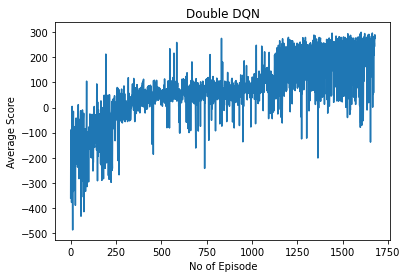

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores_doubledqn)), scores_doubledqn)
plt.ylabel('Average Score')
plt.xlabel('No of Episode')
plt.title('Double DQN')
plt.show()

### **Dueling DQN Implementation**

The architecture is same as DQN but the network is split into two streams, state value and action advantage

In [ ]:
class DuelingDQN(nn.Module):

    def __init__(self, state_size, action_size, seed):
        super(DuelingDQN, self).__init__()
        self.input_dim = state_size
        self.output_dim = action_size
        
        self.feauture_layer = nn.Sequential(
            nn.Linear(state_size, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU()
        )

        self.value_stream = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

        self.advantage_stream = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_size)
        )

    def forward(self, state):
        features = self.feauture_layer(state)
        values = self.value_stream(features)
        advantages = self.advantage_stream(features)
        qvals = values + (advantages - advantages.mean())
        
        return qvals
        

*DualingDQN Code Reference : https://towardsdatascience.com/dueling-deep-q-networks-81ffab672751*


In [ ]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # batch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4    

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
class DualingDeepQNAgent():
    """
    Operation : Agent learns from the environment using a DQN approch
    """

    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed 
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Q-Network
        self.qnetwork_local = DuelingDQN(state_size, action_size, seed).to(self.device)
        self.qnetwork_target = DuelingDQN(state_size, action_size, seed).to(self.device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        # Obtain random minibatch of tuples from D
        states, actions, rewards, next_states, dones = experiences


        q_expected = self.qnetwork_local(states).gather(1, actions)
        # q_expected = q_expected.squeeze(1)
        next_actions = self.qnetwork_local(next_states)
        q_targets_next = torch.max(next_actions, 1)[0]
        q_targets = rewards + GAMMA * q_targets_next
             
        ### Loss calculation (we used Mean squared error)
        loss = F.mse_loss(q_expected, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU) 

        # return q_expected - q_targets                    
        # loss = self.MSE_loss(curr_Q, expected_Q)
        
        return loss

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [ ]:
def DuelDeepQNTrain(n_episodes=2000, max_t=500, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

agent = DualingDeepQNAgent(state_size=8, action_size=4, seed=0)
scores_3dqn = DuelDeepQNTrain()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: UserWarning: Using a target size (torch.Size([64, 64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Episode 100	Average Score: -148.48
Episode 200	Average Score: -118.93
Episode 300	Average Score: -146.52
Episode 400	Average Score: -83.85
Episode 500	Average Score: -139.11
Episode 600	Average Score: -241.77
Episode 700	Average Score: -283.20
Episode 800	Average Score: -316.99
Episode 900	Average Score: -643.64
Episode 1000	Average Score: -617.76
Episode 1100	Average Score: -316.07
Episode 1200	Average Score: -117.96
Episode 1300	Average Score: -175.05
Episode 1400	Average Score: -297.62
Episode 1500	Average Score: -255.75
Episode 1600	Average Score: -418.20
Episode 1700	Average Score: -179.97
Episode 1800	Average Score: -329.65
Episode 1900	Average Score: -222.87
Episode 2000	Average Score: -130.41


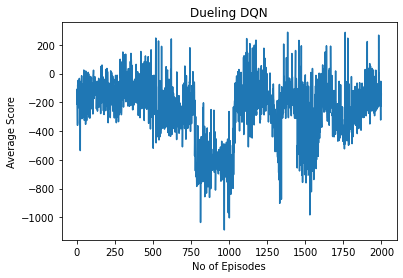

In [ ]:
#DuelingDQN 
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores_3dqn)), scores_3dqn)
plt.title('Dueling DQN')
plt.ylabel('Average Score')
plt.xlabel('No of Episodes')

plt.show()

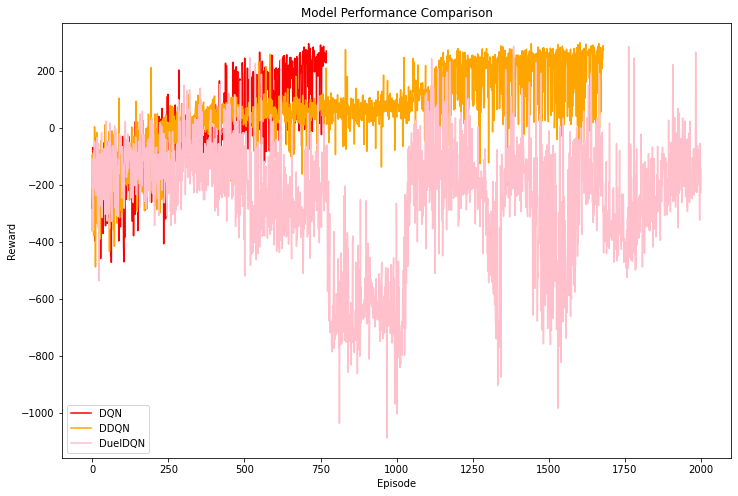

In [ ]:
from numpy.core.fromnumeric import size
plt.figure(figsize=(12,8))  

dlist = ['DQN', 'DDQN', 'DuelDQN']
# df=pd.DataFrame({'DQN':scores_dqn,'DDQN':scores_ddqn,'DuelDDQN':scores_3dqn})
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.plot(scores_dqn, 'r', label='DQN')

plt.xlabel("Episode")
plt.ylabel("Reward")
plt.plot(scores_doubledqn, 'orange',label='DDQN')

plt.xlabel("Episode")
plt.ylabel("Reward")
plt.plot(scores_3dqn,'pink',label='DuelDQN')

plt.title('Model Performance Comparison')

# agent.save('Model_dqn.h5')
plt.legend(loc=3)
# fig.savefig(reward+'.png', dpi=100)
plt.show()  

### **Dueling DQN - hidden layers decreased**

Duel Deep QNetwork did not improve in performance so reducing the number of hidden layers to check accuracy

In [ ]:


class DuelingDQN(nn.Module):

    def __init__(self, state_size, action_size, seed):
        super(DuelingDQN, self).__init__()
        self.input_dim = state_size
        self.output_dim = action_size
        
        self.feauture_layer = nn.Sequential(
            nn.Linear(state_size, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU()
        )

        self.value_stream = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

        self.advantage_stream = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, action_size)
        )

    def forward(self, state):
        features = self.feauture_layer(state)
        values = self.value_stream(features)
        advantages = self.advantage_stream(features)
        qvals = values + (advantages - advantages.mean())
        
        return qvals


In [ ]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # batch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4    

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
class DualingDeepQNAgent():
    """
    Operation : Agent learns from the environment using a DQN approch
    """

    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed 
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Q-Network
        self.qnetwork_local = DuelingDQN(state_size, action_size, seed).to(self.device)
        self.qnetwork_target = DuelingDQN(state_size, action_size, seed).to(self.device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """

        states, actions, rewards, next_states, dones = experiences

        q_expected = self.qnetwork_local(states).gather(1, actions)
        # q_expected = q_expected.squeeze(1)
        next_actions = self.qnetwork_local(next_states)
        q_targets_next = torch.max(next_actions, 1)[0]
        q_targets = rewards + GAMMA * q_targets_next
        
        ### Loss calculation (we used Mean squared error)
        loss = F.mse_loss(q_expected, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU) 

        return q_expected - q_targets                    

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [ ]:
def DuelDeepQNTrain(n_episodes=2000, max_t=500, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

agent = DualingDeepQNAgent(state_size=8, action_size=4, seed=0)
scores_dueldqn = DuelDeepQNTrain()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: UserWarning: Using a target size (torch.Size([64, 64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Episode 100	Average Score: -222.34
Episode 200	Average Score: -197.80
Episode 300	Average Score: -219.16
Episode 400	Average Score: -318.45
Episode 500	Average Score: -111.47
Episode 600	Average Score: -96.10
Episode 700	Average Score: -142.02
Episode 800	Average Score: -392.35
Episode 900	Average Score: -705.37
Episode 1000	Average Score: -441.26
Episode 1100	Average Score: -497.97
Episode 1200	Average Score: -193.97
Episode 1300	Average Score: -224.99
Episode 1400	Average Score: -195.09
Episode 1500	Average Score: -74.98
Episode 1600	Average Score: -221.51
Episode 1700	Average Score: -129.85
Episode 1800	Average Score: -268.53
Episode 1900	Average Score: -219.62
Episode 2000	Average Score: -320.26


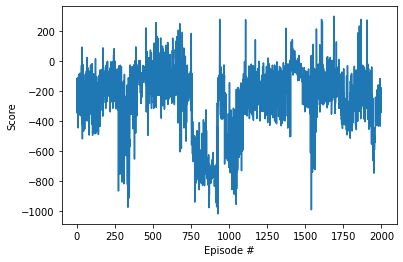

In [ ]:
#DuelingDQN - hiddenlayes * 2
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores_dueldqn)), scores_dueldqn)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

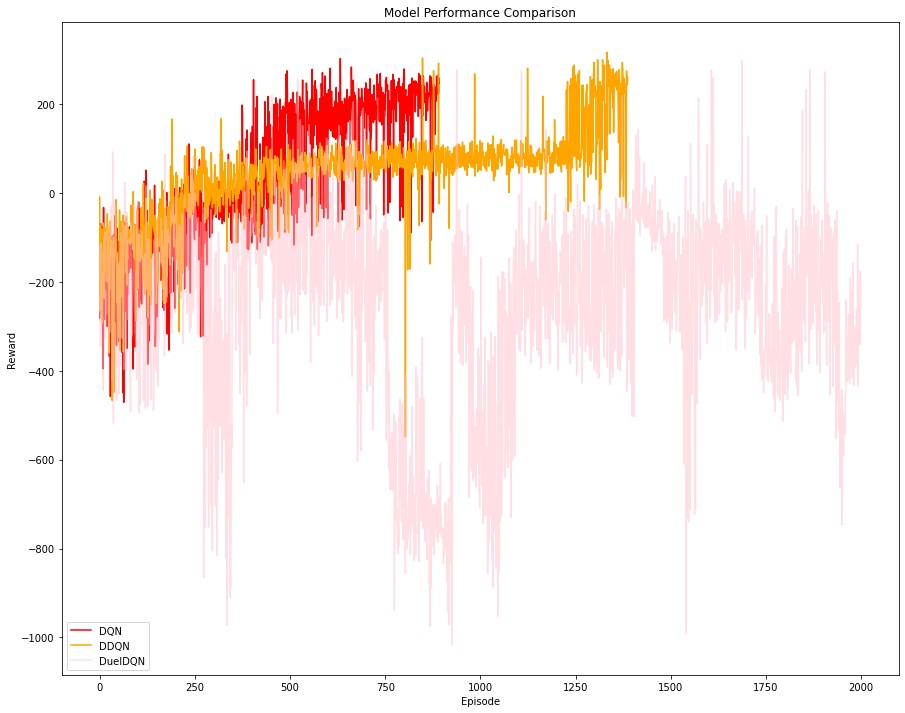

In [ ]:
from numpy.core.fromnumeric import size
plt.figure(figsize=(15,12))  

dlist = ['DQN', 'DDQN', 'DuelDQN']
# df=pd.DataFrame({'DQN':scores_dqn,'DDQN':scores_ddqn,'DuelDDQN':scores_3dqn})
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.plot(scores_dqn, 'r', label='DQN')

plt.xlabel("Episode")
plt.ylabel("Reward")
plt.plot(scores_dueldqn, 'orange',label='DDQN')

plt.xlabel("Episode")
plt.ylabel("Reward")
plt.plot(scores_dueldqn,'pink',label='DuelDQN', alpha=.5)

plt.title('Model Performance Comparison')

# agent.save('Model_dqn.h5')
plt.legend(loc=3)
# fig.savefig(reward+'.png', dpi=100)
plt.show()  

# Rendering Video

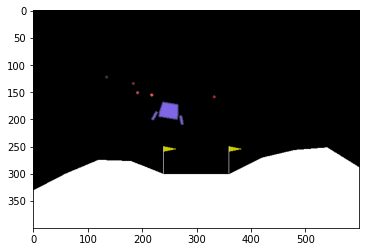

In [ ]:
env = gym.make('LunarLander-v2')
env.reset()
img = plt.imshow(env.render('rgb_array')) # only call this once
for _ in range(60):
    img.set_data(env.render('rgb_array')) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)
    action = env.action_space.sample()
    env.step(action)